### OmniXAI in a ML workflow Using Shark Research Data (August 2017-2022)

This tutorial shows how to apply XAI in different stages in a standard ML workflow. The OmniXai library is used in the example. The goal is to use prepared data from transmitters and receivers off of the Coast of Cape Cod to predict shark presence (0 or 1) in the month of August. The data is limited and prepared for use during WiDS Charlotte 2025, and can only be used for educational, not research purposes.

In [ ]:
import warnings
warnings.simplefilter("ignore")
!pip install omnixai
!pip install kaleido
# This default renderer is used for sphinx docs only. Please delete this cell in IPython.
import plotly.io as pio
pio.renderers.default = "png"
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of scikit-image to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of numba to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.9/543.9 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 592.0/592.0 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.0/32.0 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.0 MB/s eta 0:00:00


<p>The partial dataset used in this example is July 10 to August 10, allowing for a more balanced target class "#sharks".</p><p>
The dataset in this notebook can be read from: <a href="https://raw.githubusercontent.com/DrPamelaThompson/WiDS-Charlotte-2025/refs/heads/main/adult.data">GitHub</a></p>

In [ ]:
# fetch dataset from github
# Convert to DataFrame
# URL of the raw dataset without 15% of the data (holdout for prediction and validation removed)
url = "https://raw.githubusercontent.com/DrPamelaThompson/WiDS-Charlotte-2025/refs/heads/main/data_July_Aug_WiDS.csv"
# Read the CSV
df = pd.read_csv(url)
#drop na not necessary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7554 entries, 0 to 7553
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   #sharks                         7554 non-null   int64  
 1   dewF                            7554 non-null   float64
 2   tempF_air                       7554 non-null   float64
 3   datetime                        7554 non-null   object 
 4   tau_gust_mag                    7554 non-null   float64
 5   taux_gust                       7554 non-null   float64
 6   tempF_water_cat                 7554 non-null   int64  
 7   stability_value                 7554 non-null   float64
 8   tempF_water                     7554 non-null   float64
 9   precip                          7554 non-null   float64
 10  alpha                           7554 non-null   float64
 11  Tide_water_level_cat_encoded    7554 non-null   int64  
 12  unique_shark_count_cat_encoded  75

In [ ]:
df.value_counts('#sharks')

,count
#sharks,
0,3812
1,3742


In [ ]:
df.tail()

,#sharks,dewF,tempF_air,datetime,tau_gust_mag,taux_gust,tempF_water_cat,stability_value,tempF_water,precip,...,unique_shark_count_cat_encoded,Tide_ebb_flood_cat_encoded,press_change_cat_encoded,Light,tempF_Diff_encoded,press,Moon_Phase_cat,Year,Month,Day
7549,0,66.000000,74.666667,2022-08-10 19:30:00+00:00,0.015849,0.013342,3,5.592574,65.48,0.0,...,0,-1,1,Day,1,1014.438998,Waxing Gibbous,2022,8,10
7550,1,66.000000,73.866667,2022-08-10 20:00:00+00:00,0.019260,0.014495,2,5.570863,61.70,0.0,...,1,-1,1,Day,3,1014.459316,Waxing Gibbous,2022,8,10
7551,1,65.900000,72.566667,2022-08-10 21:00:00+00:00,0.017973,0.013706,2,5.494045,61.43,0.0,...,1,-1,1,Day,3,1014.287739,Waxing Gibbous,2022,8,10
7552,0,65.833333,72.233333,2022-08-10 21:30:00+00:00,0.016946,0.013035,3,5.438939,64.94,0.0,...,0,-1,1,Day,0,1013.991995,Waxing Gibbous,2022,8,10
7553,1,65.800000,71.400000,2022-08-10 22:30:00+00:00,0.020704,0.010926,3,5.475724,65.18,0.0,...,1,0,1,Day,0,1013.471620,Waxing Gibbous,2022,8,10


In [ ]:
#check balance of second target class
df.value_counts('unique_shark_count_cat_encoded')

,count
unique_shark_count_cat_encoded,
0,3812
1,3695
2,47


<p>July 12 and 13, 2022: Severe weather affected the region, with reports of heavy rainfall and strong winds impacting Cape Cod. Record numbers will be extracted for later investigation.</p>

In [ ]:
# Convert datetime column to datetime format (if not already)
df["datetime"] = pd.to_datetime(df["datetime"])

# Find the index (record number) for July 12, 2022
record_index = df[df["datetime"] == "2022-07-12"].index

# Display the record number(s)
print("Record number(s) for July 12, 2022:", record_index.tolist())

Record number(s) for July 12, 2022: [6397]


<p>The target is #sharks and a second target, not used, is unique_shark_count_cat_encoded</p>
<p>Let's first check if some features are correlated and if there exists data imbalance issues that leads to any potential bias. We can create an `DataAnalyzer` explainer from OmniXai to do this task.</p>

In [ ]:
df1 = df.drop(columns=['datetime','unique_shark_count_cat_encoded','Year','Month','Day'])

Correlation:


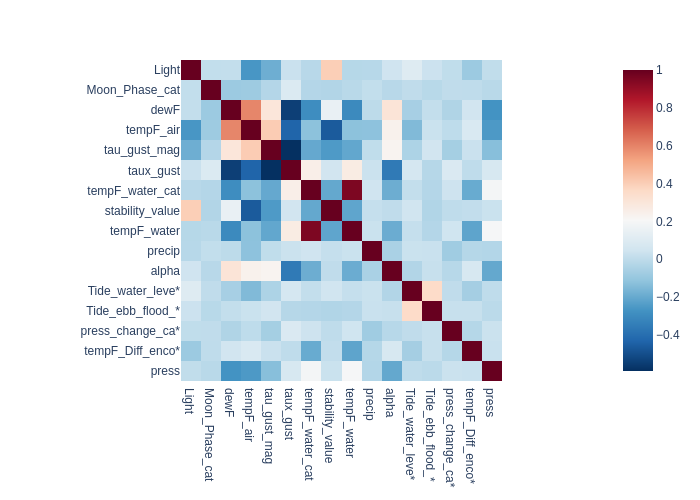

Imbalance#0: features tempF_water_cat


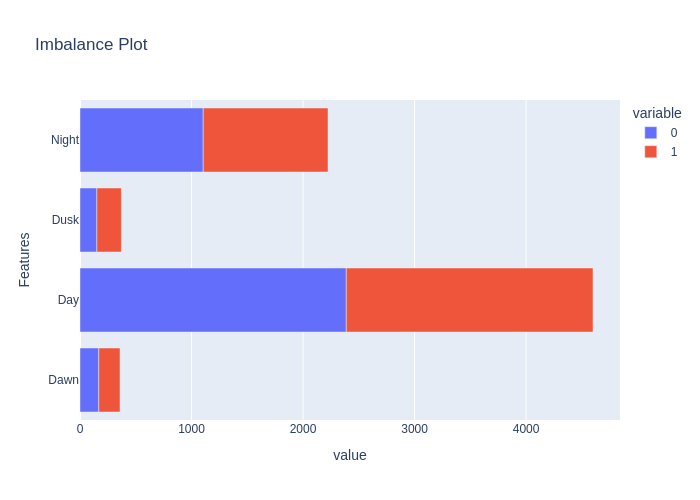

Imbalance#1: features tempF_water


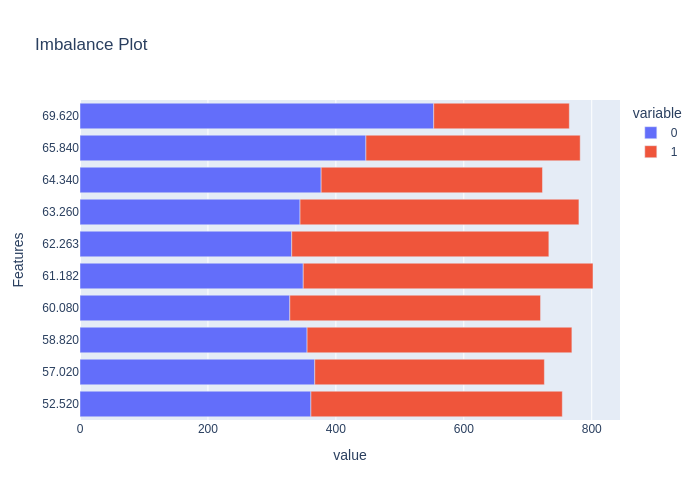

Imbalance#2: features Light, tempF_water


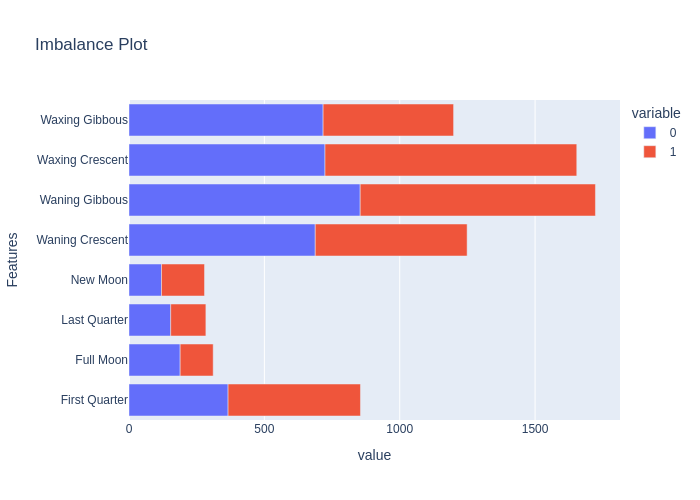

In [ ]:
from omnixai.data.tabular import Tabular
from omnixai.explainers.data import DataAnalyzer

tabular_data = Tabular(
    df1,
    categorical_columns=['Light','Moon_Phase_cat'],
    target_column='#sharks'
)

# Initialize a `DataAnalyzer` explainer.
# We can choose multiple explainers/analyzers by specifying analyzer names.
# In this example, the first explainer is for feature correlation analysis and
# the others are for feature imbalance analysis (the same explainer with different parameters).
explainer = DataAnalyzer(
    explainers=["correlation", "imbalance#0", "imbalance#1", "imbalance#2"],
    mode="classification",
    data=tabular_data
)
# Generate explanations by calling `explain_global`.
explanations = explainer.explain_global(
    params={"imbalance#0": {"features": ["Light"]},
            "imbalance#1": {"features": ["tempF_water"]},
            "imbalance#2": {"features": ["Moon_Phase_cat"]},
            "imbalance#3": {"features": ["Light", "tempF_water"]}}
)

print("Correlation:")
explanations["correlation"].ipython_plot()
print("Imbalance#0: features tempF_water_cat")
explanations["imbalance#0"].ipython_plot()
print("Imbalance#1: features tempF_water")
explanations["imbalance#1"].ipython_plot()
print("Imbalance#2: features Light, tempF_water")
explanations["imbalance#2"].ipython_plot()

From the correlation plot we can observe that "tempF_water" has strong correlations with "tempF_water_cat", so we may remove one of these features. We will also remove taus_gust based on domain information. From the data imbalance plots we can see that the class labels are relatively balanced in the features.

In [ ]:
df2 = df1.drop(columns=["tempF_water_cat", "taux_gust"])
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7554 entries, 0 to 7553
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   #sharks                       7554 non-null   int64  
 1   dewF                          7554 non-null   float64
 2   tempF_air                     7554 non-null   float64
 3   tau_gust_mag                  7554 non-null   float64
 4   stability_value               7554 non-null   float64
 5   tempF_water                   7554 non-null   float64
 6   precip                        7554 non-null   float64
 7   alpha                         7554 non-null   float64
 8   Tide_water_level_cat_encoded  7554 non-null   int64  
 9   Tide_ebb_flood_cat_encoded    7554 non-null   int64  
 10  press_change_cat_encoded      7554 non-null   int64  
 11  Light                         7554 non-null   object 
 12  tempF_Diff_encoded            7554 non-null   int64  
 13  pre

In the next step, we do a rough feature selection by analyzing the information gain and chi-squared stats between features and targets.
<ul><b>Interpretation:</b>
<li>Mutual Information tells you how much knowing a feature reduces uncertainty about the target.
<li>Chi-Square tells you whether there is a statistically significant relationship between a categorical feature and the target.
</ul>
<ul><b>Practical Explanation Using Your Code</b>
<li>
If "Mutual Information" for Light is high, it means Light helps predict #sharks well.
<li>If "Chi-Square" for Light is significant, it means LIght and #sharks are not independent, but it doesn’t tell us how much it improves prediction. Chi-Square goes from 0 to infinity - the larger the value the more the dependence between the features.
</ul>
<p>
Mutual information is better for feature selection in machine learning, while chi-square is useful for statistical hypothesis testing.</p>
<p><b>Example:</b> Let's say we're analyzing Education Level vs. Income Group:
<br>
Chi-Square might only tell us if there's a relationship.<br>
Mutual Information tells us how much knowing Education Level helps predict Income Group.<br></p>

<p><b>Feature Importance for model can be explained globally or locally:</b><br>

<b>Global Feature Importance: </b> How important each feature is for the entire dataset.<br>
<b>Local Feature Importance: </b>How important each feature is for a single prediction.<br>
</p>

Mutual information:


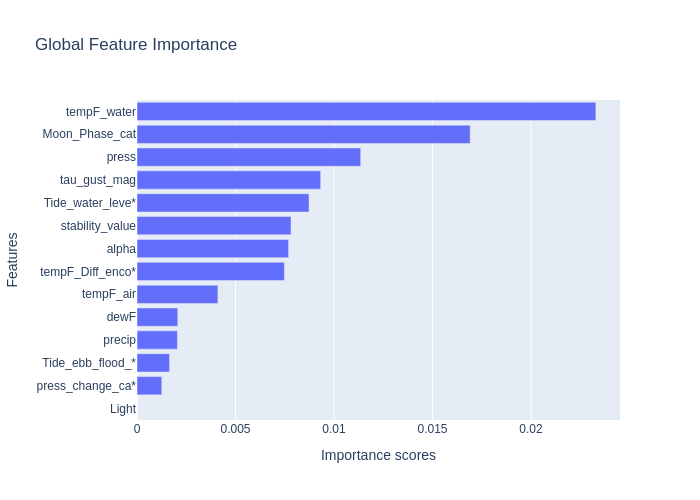

Chi square:


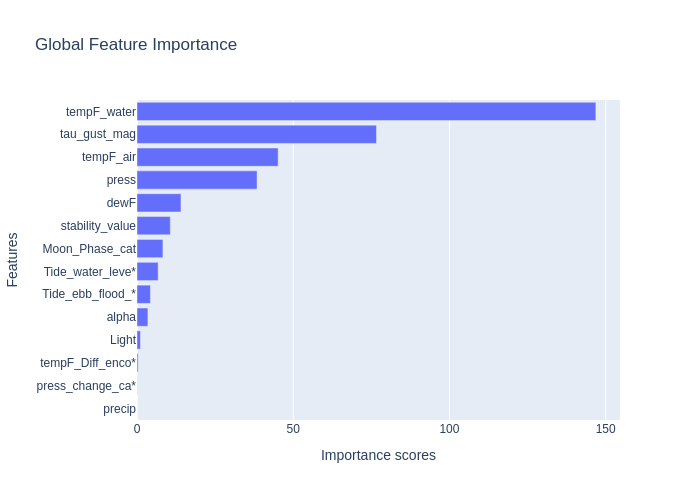

In [ ]:
tabular_data = Tabular(
    df2,
    categorical_columns=['Light', 'Moon_Phase_cat'],
    target_column='#sharks'
)
explainer = DataAnalyzer(
    explainers=["mutual", "chi2"],
    mode="classification",
    data=tabular_data
)
data_explanations = explainer.explain_global()

print("Mutual information:")
data_explanations["mutual"].ipython_plot()
print("Chi square:")
data_explanations["chi2"].ipython_plot()

The most important features showed above are "tempF_water", "tau_gust_mag", "tempF_air", "press", "dewF", "stability_value", "Moon_Phase_cat", "Tide_water_level", "Tide_ebb_flood_cat", and "alpha". Domain information will guide us to keep all but tempF_Diff_encoded" and "press_change_cat" in the dataframe for modeling.

In [ ]:
# We drop this features because the feature has relatively low importance scores.
df3 = df2.drop(columns=["tempF_Diff_encoded"])
tabular_data = Tabular(
    df3,
    categorical_columns=['Light', 'Moon_Phase_cat'],
    target_column='#sharks'
)
print(tabular_data)

      #sharks       dewF  tempF_air  tau_gust_mag  stability_value  \
0           1  59.766667  72.000000      0.018456         4.070020   
1           1  59.666667  71.566667      0.017939         4.730586   
2           1  61.100000  71.300000      0.014427         5.391153   
3           1  61.533333  70.700000      0.011222         5.623745   
4           1  61.900000  70.066667      0.010072         5.856337   
...       ...        ...        ...           ...              ...   
7549        0  66.000000  74.666667      0.015849         5.592574   
7550        1  66.000000  73.866667      0.019260         5.570863   
7551        1  65.900000  72.566667      0.017973         5.494045   
7552        0  65.833333  72.233333      0.016946         5.438939   
7553        1  65.800000  71.400000      0.020704         5.475724   

      tempF_water  precip     alpha  Tide_water_level_cat_encoded  \
0          56.660     0.0  0.239841                             1   
1          56.435    

<p>Train two models:<br>
1. XGBoost classifier<br>
2. Random Forest Classifier</p>

<p>Training XGBoost and Random Forest together can be useful because they have different strengths and weaknesses. Using both allows you to compare performance, interpret feature importance, and potentially combine their outputs for better predictions.</p>
<p>
<table>
    <thead>
        <tr>
            <th>Factor</th>
            <th>When to Use RF</th>
            <th>When to Use XGBoost</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td><strong>Dataset Size</strong></td>
            <td>Small to medium</td>
            <td>Large datasets</td>
        </tr>
        <tr>
            <td><strong>Missing Data</strong></td>
            <td>Handles missing values well</td>
            <td>Requires imputation</td>
        </tr>
        <tr>
            <td><strong>Overfitting Risk</strong></td>
            <td>Lower</td>
            <td>Higher, but tunable</td>
        </tr>
        <tr>
            <td><strong>Training Time</strong></td>
            <td>Faster on small datasets</td>
            <td>Faster on large datasets</td>
        </tr>
        <tr>
            <td><strong>Interpretability</strong></td>
            <td>Easier to explain</td>
            <td>Harder to interpret</td>
        </tr>
        <tr>
            <td><strong>Performance on Complex Data</strong></td>
            <td>Good, but may miss subtle patterns</td>
            <td>Captures complex relationships better</td>
        </tr>
    </tbody>
</table></p>

In [ ]:
import sklearn
import xgboost
from omnixai.preprocessing.tabular import TabularTransform

np.random.seed(12345)
# Train an XGBoost model
transformer = TabularTransform().fit(tabular_data)
x = transformer.transform(tabular_data)
train, test, train_labels, test_labels = sklearn.model_selection.train_test_split(
    x[:, :-1], x[:, -1], train_size=0.80, stratify=x[:, -1]
)
print('Training data shape: {}'.format(train.shape))
print('Test data shape:     {}'.format(test.shape))

class_names = transformer.class_names
#
gbtree = xgboost.XGBClassifier(
    objective="binary:logistic",
    n_estimators=700,     # More trees for better learning
    learning_rate=0.1,   # Lower learning rate to generalize better
    max_depth=7,          # Slightly deeper trees
    subsample=0.9,        # Use 85% of data per tree
    colsample_bytree=1, # Use 80% of features per tree
    gamma=2,              # Avoid unnecessary splits
    reg_lambda=3,         # Add regularization
    reg_alpha=1           # Helps with feature selection
)
gbtree.fit(train, train_labels)
print('Test accuracy: {}'.format(
    sklearn.metrics.accuracy_score(test_labels, gbtree.predict(test))))
# Convert the transformed data back to Tabular instances
train_data = transformer.invert(train)
test_data = transformer.invert(test)

Training data shape: (6043, 23)
Test data shape:     (1511, 23)
Test accuracy: 0.6690933156849769


In [ ]:
np.random.seed(12345)
# Train an Random Forest model
transformer = TabularTransform().fit(tabular_data)
x = transformer.transform(tabular_data)
train, test, train_labels, test_labels = sklearn.model_selection.train_test_split(
    x[:, :-1], x[:, -1], train_size=0.80, stratify=x[:, -1]
)
print('Training data shape: {}'.format(train.shape))
print('Test data shape:     {}'.format(test.shape))

class_names = transformer.class_names
# Train Random Forest on your training data
rf_model = RandomForestClassifier(
    n_estimators=1000,     # Increase trees for better learning
    max_depth=12,         # Limit tree depth to avoid overfitting
    min_samples_split=4,  # Prevent too many small splits
    min_samples_leaf=3,   # Avoid overfitting small leaf nodes
    max_features=.8,  # Select a subset of features per tree
    class_weight="balanced",  # Handle class imbalance
    random_state=42,
    n_jobs=-1  # Use all CPU cores for faster training
)
# The line below has been modified to use the transformed data 'train' instead of 'train_data'
rf_model.fit(train, train_labels)  # Use the transformed data for training
#
print('Test accuracy: {}'.format(
    sklearn.metrics.accuracy_score(test_labels, rf_model.predict(test))))

# Convert the transformed data back to Tabular instances
train_data = transformer.invert(train)
test_data = transformer.invert(test)

Training data shape: (6043, 23)
Test data shape:     (1511, 23)
Test accuracy: 0.6843150231634679


We then create an `TabularExplainer` explainer to generate local and global explanations.

In [ ]:
from omnixai.explainers.tabular import TabularExplainer

# Initialize a TabularExplainer
explainers = TabularExplainer(
    explainers=["lime", "shap", "mace", "pdp", "ale"],
    mode="classification",
    data=train_data,
    model=rf_model,
    preprocess=lambda z: transformer.transform(z),
    params={
        "lime": {"kernel_width": 3},
        "shap": {"nsamples": 100},
        "mace": {"ignored_features": ["tempF_Diff_encoded"]}
    }
)

<p>Interpretation of first chart: for Dusk, the model strongly favors Class = 1 (Red Line for Class 1) rather than Class 0 (Blue Line for Class 0)</p>
<p>You can plot just Class 1 line to more easily interpret the charts.</p>

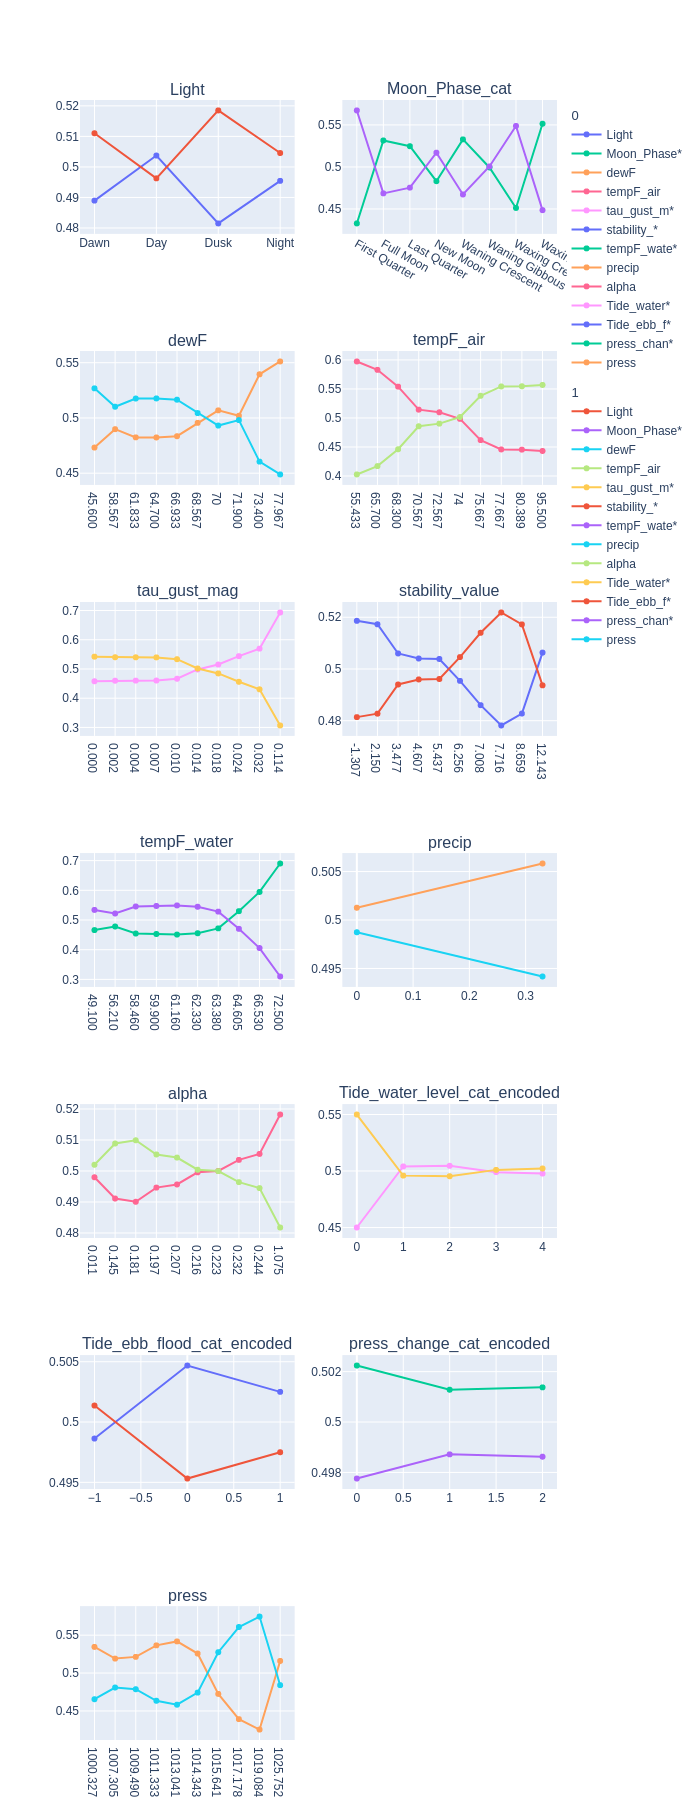

In [ ]:
# Generate global explanations
global_explanations = explainers.explain_global()
global_explanations["pdp"].ipython_plot(class_names=class_names)
#The separation between the two lines shows that the model sees a clear difference

<p>PDP compared to ALE</p>
<p>
<table border="1" cellspacing="4" cellpadding="7">
    <thead>
        <tr>
            <th>Method</th>
            <th>Explanation</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td><strong>PDP Example:</strong> How Does "Light" (Dawn, Day, Dusk, Night) Affect Predictions?</td>
            <td>
                PDP shows how changing "Light" affects the probability of Class 1 <strong>on average</strong>.<br>
                If "Night" has a <strong>higher probability of Class 1</strong>, it suggests that "Night" is predictive of an event.<br>
                <strong>Problem:</strong> If "Light" is correlated with "Moon Phase" (e.g., Full Moons often happen at night), PDP might overestimate the effect of "Light".
            </td>
        </tr>
        <tr>
            <td><strong>ALE Example:</strong> How Does "Light" Affect Predictions?</td>
            <td>
                ALE looks at <strong>small changes</strong> in "Light" and their direct impact.<br>
                If "Light" is correlated with "Moon Phase", ALE adjusts for that correlation.<br>
                Instead of showing a global trend, ALE focuses on <strong>how much predictions change</strong> in different Light conditions.
            </td>
        </tr>
    </tbody>
</table></p>


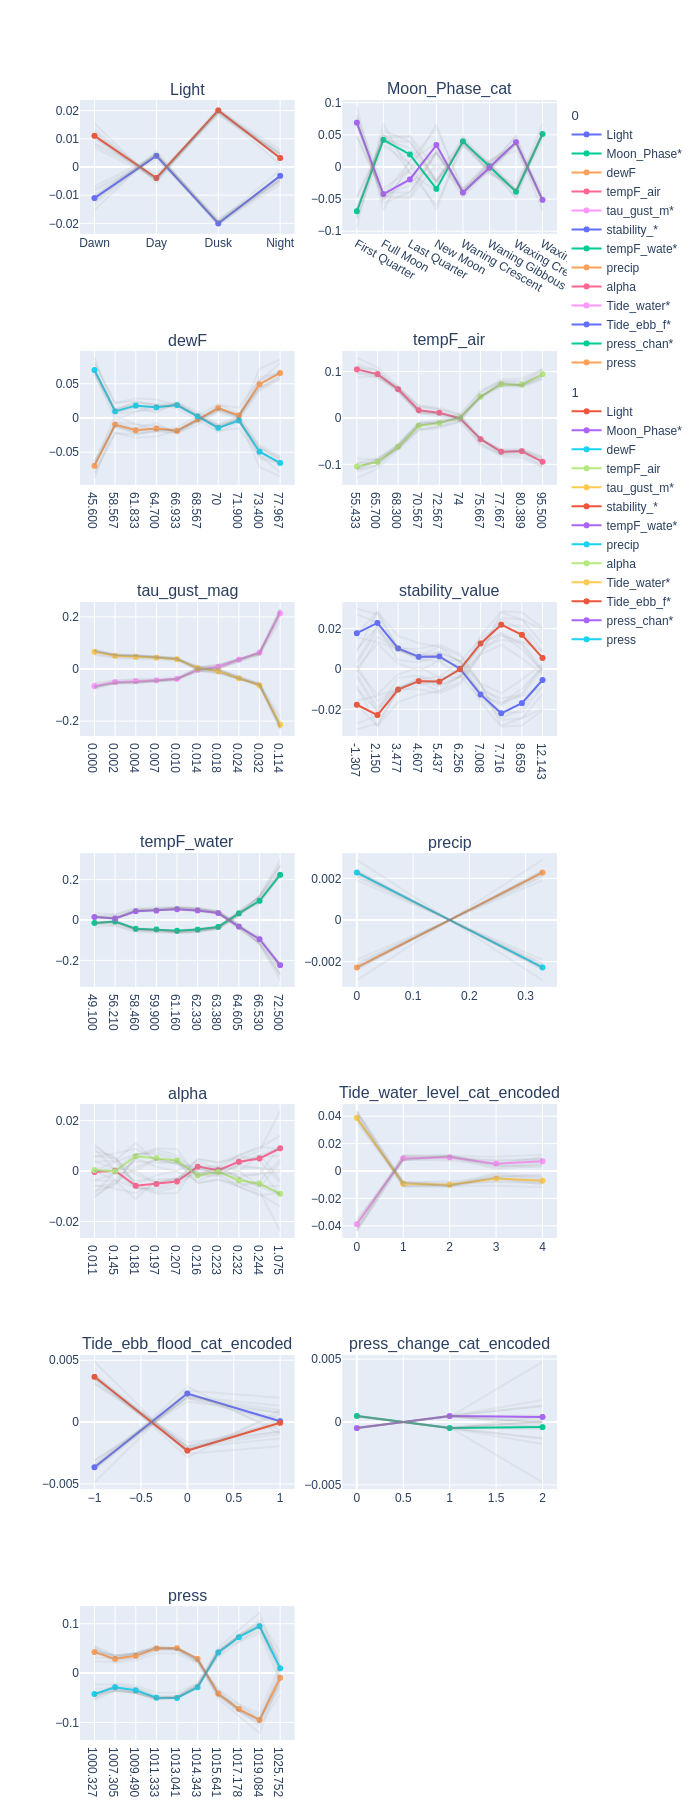

In [ ]:
global_explanations["ale"].ipython_plot(class_names=class_names)

For some specific test instances, we can generate local explanations to analyze the predictions.

In [ ]:
num_records = len(test_data)
print("Number of records in test_data:", num_records)

Number of records in test_data: 1511


<p>Find five consecutive recs that have both classes, 0 and 1, represented.</p>

In [ ]:
import numpy as np

# Convert test labels to a NumPy array if not already
test_labels_array = np.array(test_labels)

# List to store valid index ranges
valid_ranges = []

# Iterate through test_labels to find consecutive 5-record ranges containing both 0s and 1s
for i in range(len(test_labels_array) - 4):  # -4 to ensure last 5 elements are checked
    subset = test_labels_array[i:i+5]  # Get 5 consecutive records
    unique_vals = np.unique(subset)  # Find unique values in the subset

    if len(unique_vals) == 2:  # Check if both 0 and 1 are present
        valid_ranges.append((i, i+5))  # Store start and end index

# Print all valid ranges
print("Valid consecutive index ranges with both 0s and 1s:")
for start, end in valid_ranges:
    print(f"Index range {start}:{end} -> Labels: {test_labels_array[start:end]}")


Valid consecutive index ranges with both 0s and 1s:
Index range 0:5 -> Labels: [0. 1. 0. 0. 0.]
Index range 1:6 -> Labels: [1. 0. 0. 0. 0.]
Index range 2:7 -> Labels: [0. 0. 0. 0. 1.]
Index range 3:8 -> Labels: [0. 0. 0. 1. 0.]
Index range 4:9 -> Labels: [0. 0. 1. 0. 1.]
Index range 5:10 -> Labels: [0. 1. 0. 1. 0.]
Index range 6:11 -> Labels: [1. 0. 1. 0. 0.]
Index range 7:12 -> Labels: [0. 1. 0. 0. 1.]
Index range 8:13 -> Labels: [1. 0. 0. 1. 0.]
Index range 9:14 -> Labels: [0. 0. 1. 0. 0.]
Index range 10:15 -> Labels: [0. 1. 0. 0. 1.]
Index range 11:16 -> Labels: [1. 0. 0. 1. 0.]
Index range 12:17 -> Labels: [0. 0. 1. 0. 1.]
Index range 13:18 -> Labels: [0. 1. 0. 1. 1.]
Index range 14:19 -> Labels: [1. 0. 1. 1. 0.]
Index range 15:20 -> Labels: [0. 1. 1. 0. 0.]
Index range 16:21 -> Labels: [1. 1. 0. 0. 0.]
Index range 17:22 -> Labels: [1. 0. 0. 0. 0.]
Index range 19:24 -> Labels: [0. 0. 0. 0. 1.]
Index range 20:25 -> Labels: [0. 0. 0. 1. 0.]
Index range 21:26 -> Labels: [0. 0. 1. 0. 0

  0%|          | 0/5 [00:00<?, ?it/s]


Explaining instance at index 1473:
LIME results:


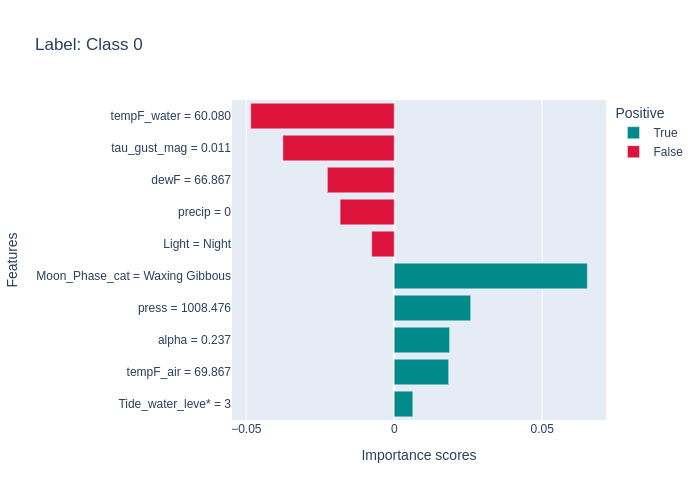

SHAP results:


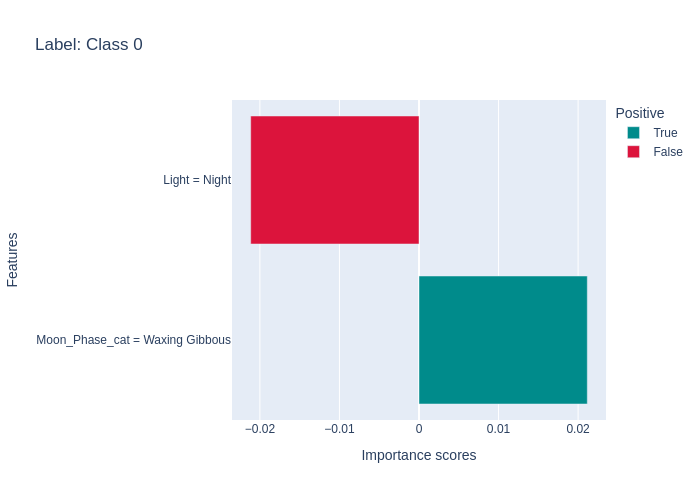

MACE results:


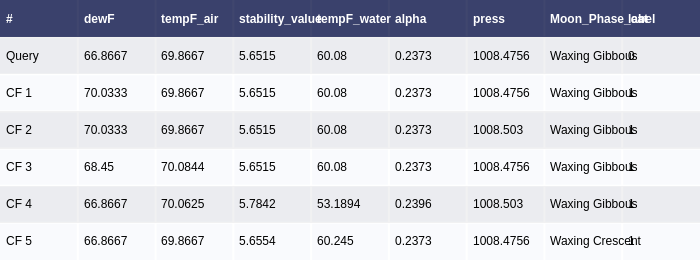

<Figure size 2000x1000 with 0 Axes>


Explaining instance at index 1474:
LIME results:


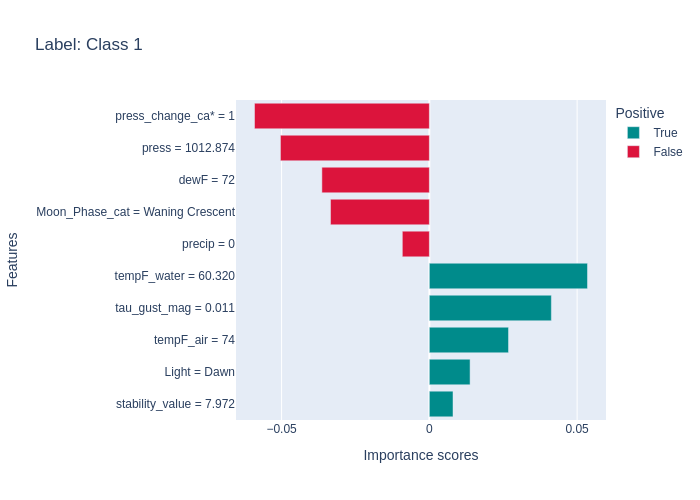

SHAP results:


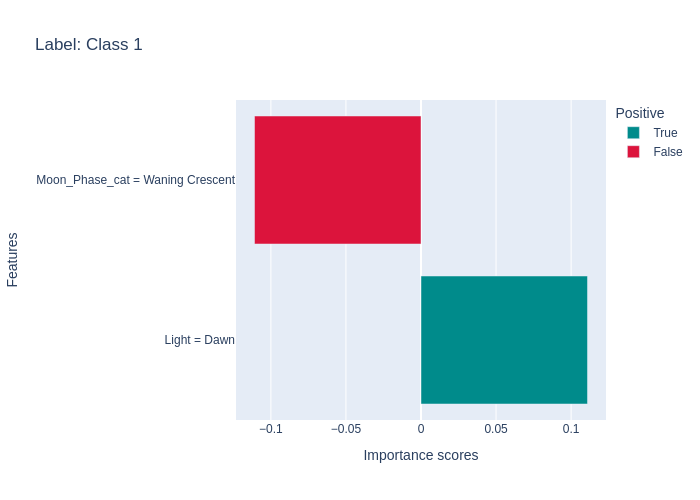

MACE results:


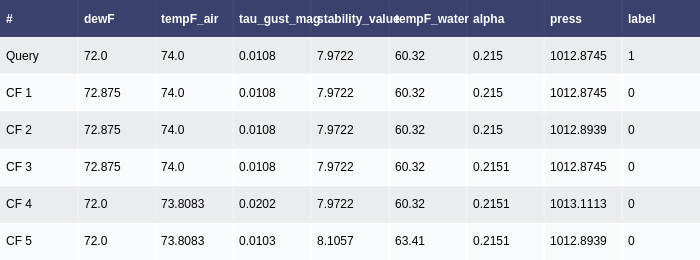

<Figure size 2000x1000 with 0 Axes>


Explaining instance at index 1475:
LIME results:


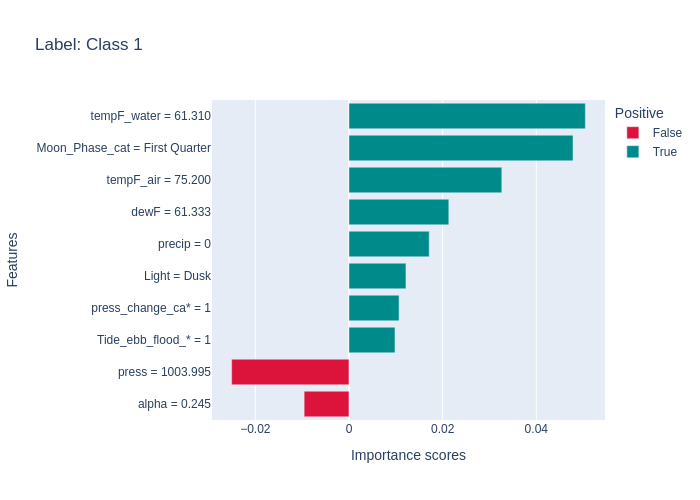

SHAP results:


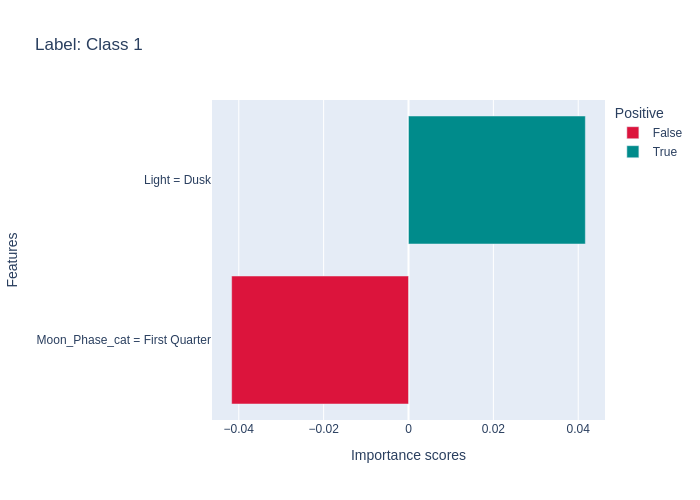

MACE results:


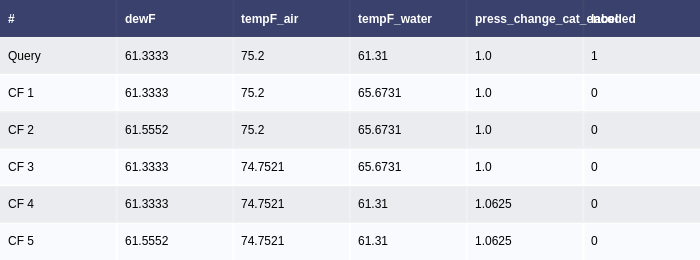

<Figure size 2000x1000 with 0 Axes>


Explaining instance at index 1476:
LIME results:


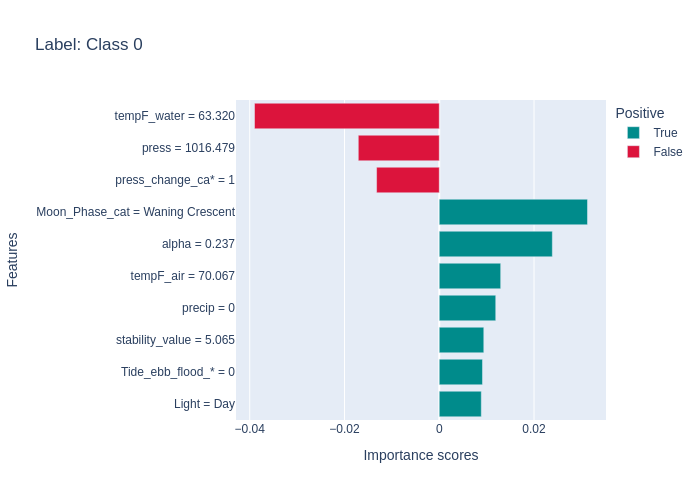

SHAP results:


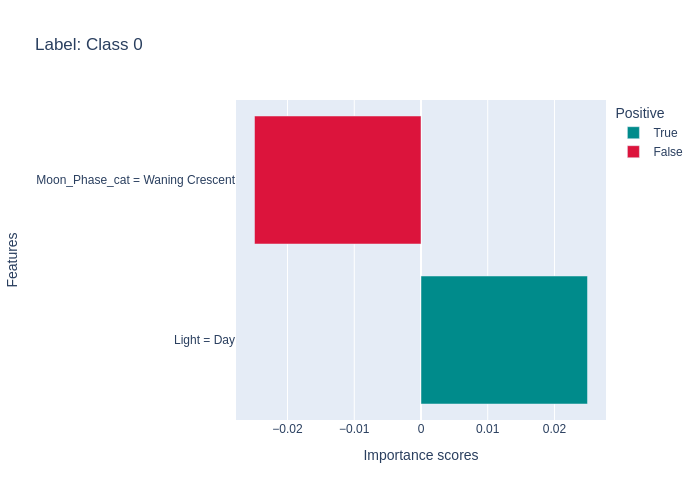

MACE results:


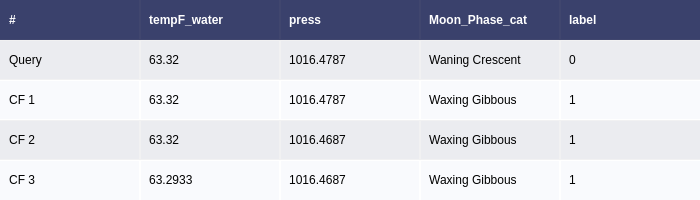

<Figure size 2000x1000 with 0 Axes>


Explaining instance at index 1477:
LIME results:


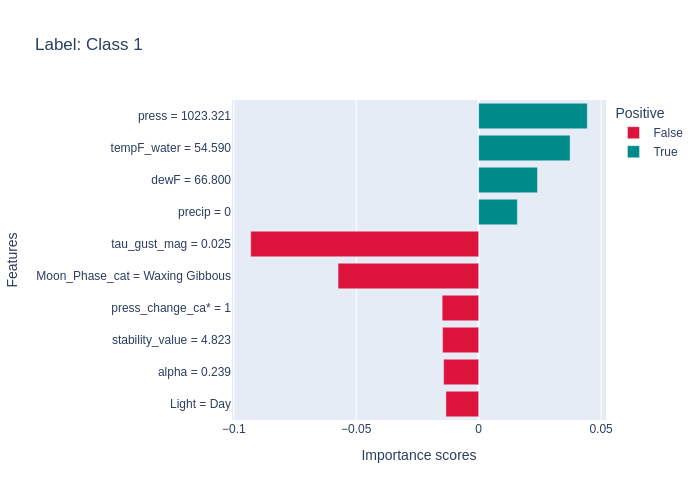

SHAP results:


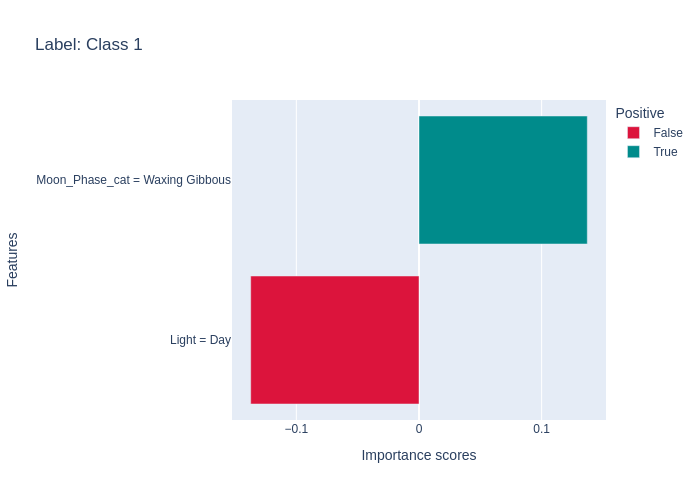

MACE results:


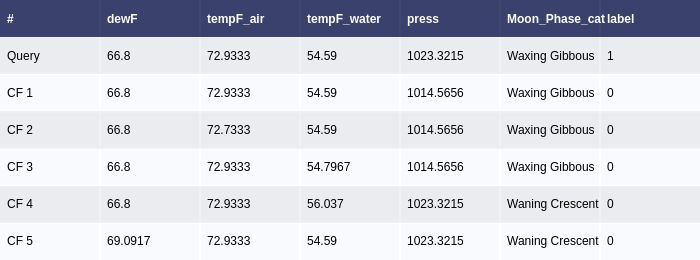

<Figure size 2000x1000 with 0 Axes>

In [ ]:
# Generate local explanations for selected test instances
test_instances = test_data[1473:1478]  # Select 5 consecutive records
local_explanations = explainers.explain(X=test_instances)  # Generate explanations

# Loop through all selected test instances
for i in range(len(test_instances)):
    print(f"\nExplaining instance at index {1473 + i}:")  # Show original index

    print("LIME results:")
    local_explanations["lime"].ipython_plot(i, class_names=class_names)

    print("SHAP results:")
    local_explanations["shap"].ipython_plot(i, class_names=class_names)

    print("MACE results:")

    # Increase figure width before plotting MACE
    import matplotlib.pyplot as plt
    plt.figure(figsize=(20, 10))  # Adjust width (increase first number)

    # Plot MACE results
    local_explanations["mace"].ipython_plot(i, class_names=class_names)

    # Show the adjusted figure
    plt.show()

The results of LIME and SHAP show the feature importance scores for this prediction, MACE generates several counterfactual examples.

We can create a `PredictionAnalyzer` for computing performance metrics for this task:

In [ ]:
# Compute metrics
from omnixai.explainers.prediction import PredictionAnalyzer

analyzer = PredictionAnalyzer(
    mode="classification",
    test_data=test_data,
    test_targets=test_labels,
    model=gbtree,
    preprocess=lambda z: transformer.transform(z)
)
prediction_explanations = analyzer.explain()

metric:


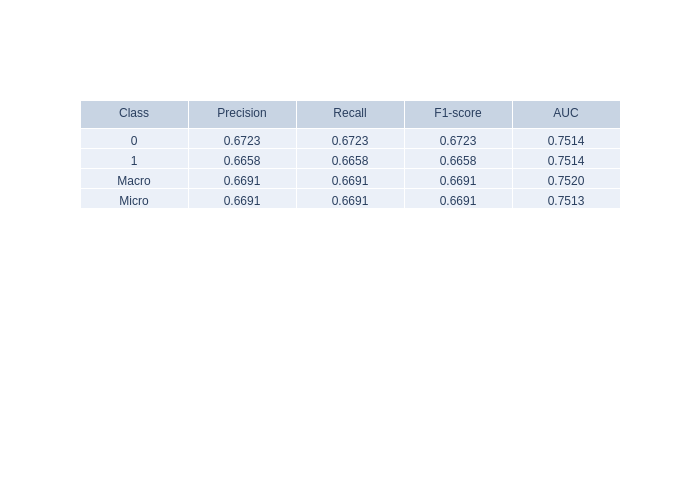

confusion_matrix:


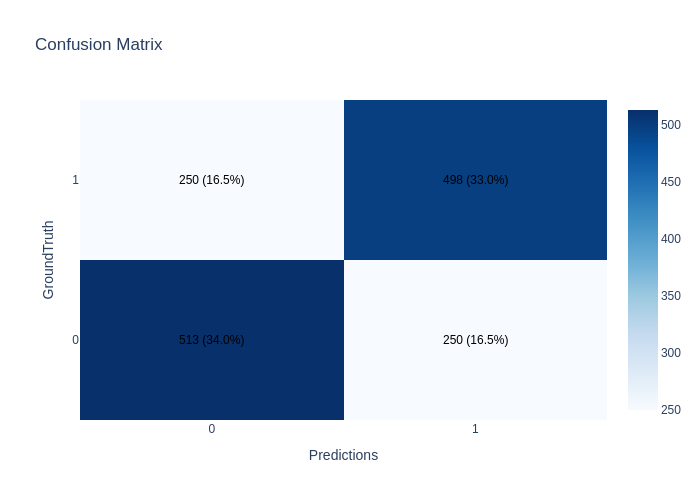

roc:


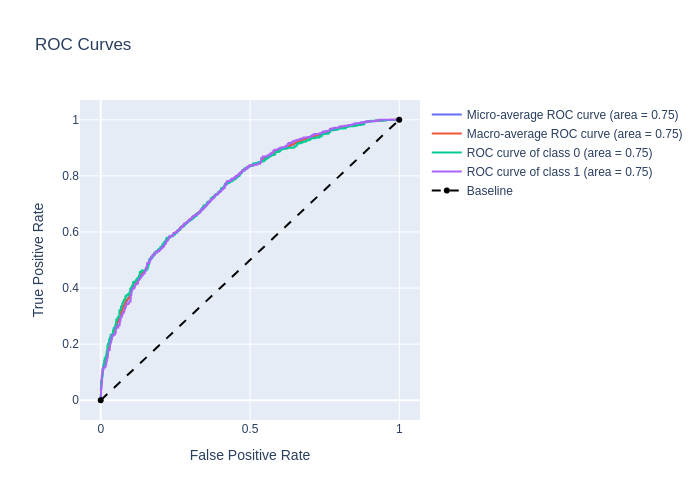

precision_recall:


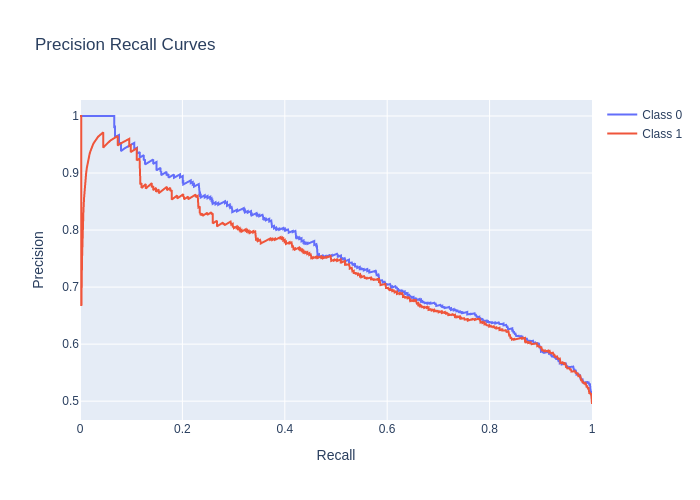

cumulative_gain:


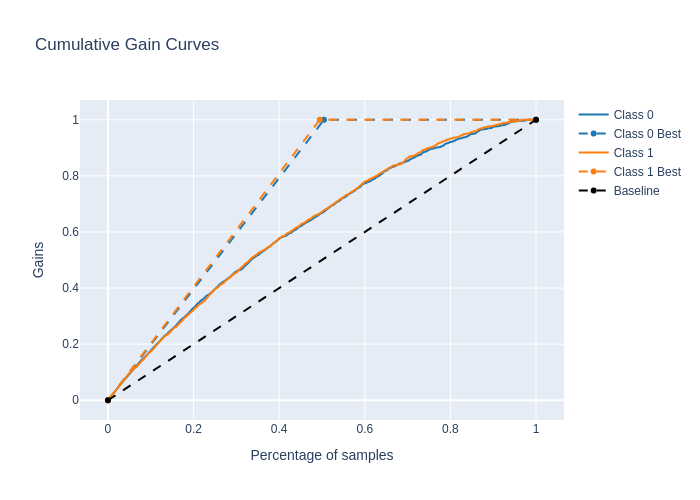

lift_curve:


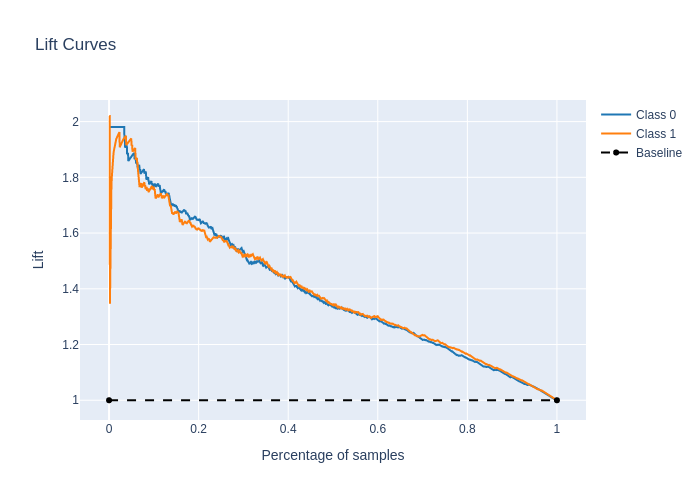

In [ ]:
for name, metrics in prediction_explanations.items():
    print(f"{name}:")
    metrics.ipython_plot(class_names=class_names)

We can launch a dashboard to examine all the explanations:

In [ ]:
!pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


In [ ]:
!pip install jupyter-dash

In [ ]:
!pip install dash-bootstrap-components

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.3/229.3 kB 7.1 MB/s eta 0:00:00


In [ ]:
from omnixai.visualization.dashboard import Dashboard

# Launch a dashboard for visualization
dashboard = Dashboard(
    instances=test_instances,
    data_explanations=data_explanations,
    local_explanations=local_explanations,
    global_explanations=global_explanations,
    prediction_explanations=prediction_explanations,
    class_names=class_names
)
dashboard.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<p>License & Citation<br>
OmniXAI is released under the Apache 2.0 License, allowing free use for research and presentations.<br>

Reference:<br>
"Explanations generated using OmniXAI (Salesforce Research, Apache 2.0 License)."<br>
GitHub Repository: https://github.com/salesforce/OmniXAI<br></p>